# Overview
Building a simple Q&A application over a text data source.

Also using LangSmith to trace and understand our application.

A typical RAG application has two main components:
*   **Indexing:** a pipeline for ingesting data from a source and indexing it. (Usually happens offline)
*   **Retrieval and generation:** The actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.


### Indexing
**Load:** First we need to load our data. This is done with Document Loaders

**Split:** Text splitters -> Break large Documents into smaller chunks. Useful for indexing data and passing into a model.

**Store:** Somewhere to store and index our splits, so they can be searched over later. Done using VectorStore and Embeddings model.

### Retrieval and Generation

**Retrieve:** Given user input, splits are retrieved using a Retriever.

**Generate:** A Model/LLM will produce an answer using a prompt that includes both the question with the retrieved data.

In [1]:
%pip install --quiet langchain-text-splitters langchain-community langgraph langchain langchain-openai langchain-core

**LangSmith Setup**

In [2]:
import getpass
import os

os.environ["LANGCHAIN_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

··········


In [5]:
%pip install google-ai-generativelanguage==0.6.17
%pip install -qU langchain-google-genai==2.1.3 --no-deps
%pip install -qU "langchain[google-genai]"

# This will be the Chat Model

In [6]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google API key: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

# This will be the embeddings model

In [7]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter the API key for Google: ")

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# This will be the Vector store (In Memory)

In [8]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In this project, we can ask the chatbot questions about this article: https://lilianweng.github.io/posts/2023-06-23-agent/

# Indexing

### **Load**
First load the blog post contents, can be done using Document Loaders.

Using WebBaseLoader() -> loads HTML from web Url's and uses BeautifulSoup to parse it to text. HTML can also be customized by passing parameters into the BeautifulSoup parser from bs_kwargs.

In this case, HTML tags with classes named "post-content", "post-title", or "post-header" are relevant, so we can filter out all the others.

In [10]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Keeping on the post title, headers, and content
bs4_strainer = bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))
loader = WebBaseLoader(
    web_paths = ("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs = {"parse_only": bs4_strainer},
)

docs = loader.load()

### **Split**

Loaded document is over 42k characters, too long to fit into the context window of a lot of models.

So, split the Document into chunks for embedding and vector storage. So we can retrieve only the most relevant parts of the blog post at run time.

RecursiveCharacterTextSplitter() -> recursively split the document using common sparators (e.g. new lines) until each chunk is the appropriate size.

This is the generic text splitter for generic text use cases:

In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000, # characters
    chunk_overlap = 200, # characters
    add_start_index = True, # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split the text into {len(all_splits)} sub_documents")

Split the text into 63 sub_documents


### **Store**

We index our 66 text chunks so that we can search over them at runtime.

We embed the contents of each document split and insert these embeddings into a vector store.

Given an input query, we can use vector search to retrieve relevant documents.

We can embed and store all the document splits in a single command with the vector store and embeddings model that we chose before.

In [12]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['858cbab9-9f82-4fa0-9ada-bd1274ad23a9', '0a20a642-ac92-4857-b5d5-1e2ea15854f5', '5135de7a-b46a-4c84-90a1-853fc5d23844']


Indexing is done, Now we have a query-able vector store containing the chunked contents of the blog post.

So, given a user question, we should be able to return the snippets of the blog post that answer the question.

# Retrieval and Generation

Program takes a user question -> searches for documents relevant to that question -> passes the retireved documents and inital question to a model -> returns and answer.

This is the prompt, I'm going to pull it from the LangChain prompt hub: https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=3f0db39c-e77a-4849-9974-83f92652d4fb

In [13]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


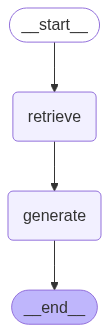

Context: [Document(id='5135de7a-b46a-4c84-90a1-853fc5d23844', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth

In [17]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
  question: str
  context: List[Document]
  answer: str

def retrieve(state: State):
  retrieved_docs = vector_store.similarity_search(state["question"])
  return {"context": retrieved_docs}

def generate(state: State):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = prompt.invoke({"question": state["question"], "context": docs_content})
  response = llm.invoke(messages)
  return {"answer": response.content}

# Connecting the retrieval and generation steps into a single sequence
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')